In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table


In [2]:
from astroquery.gaia import Gaia

In [213]:
ra, dec = 93.5955 , -69.84858333




if 1:
    query = '''SELECT g.source_id, g.ra, g.dec, g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag,
    g.pmra, g.pmdec, g.pm, g.pmra_error, g.pmdec_error, g.pmra_pmdec_corr, DISTANCE(
    POINT({}, {}),
    POINT(g.ra, g.dec)) AS ang_sep
    FROM gaiadr3.gaia_source AS g
    WHERE 1 = CONTAINS(
    POINT({}, {}),
    CIRCLE(ra, dec, 0.2))
    AND g.astrometric_params_solved >= 31
    AND g.pmra is not null
    AND g.pmdec is not null
    AND g.phot_g_mean_mag is not null
    AND g.phot_bp_mean_mag - g.phot_rp_mean_mag <= 0.75
    AND DISTANCE(
    POINT({}, {}),
    POINT(g.ra, g.dec)) > 0.05
    '''.format(ra, dec, ra, dec, ra, dec)
    
job = Gaia.launch_job_async(query)
gc = job.get_results()
gc = gc.to_pandas()
len(gc)

INFO: Query finished. [astroquery.utils.tap.core]


3705

In [215]:
gc.to_csv('sHodge-11.csv')

In [216]:
values = get_mean_pm(gc.ra, gc.dec, gc.pmra, gc.pmdec, gc.pmra_error, gc.pmdec_error, gc.pmra_pmdec_corr, sigma=None, rsigma=numpy.inf, covfnc=covfncpm)

In [217]:
values

(1.652400190877052,
 0.9086668803416271,
 0.026056396015029595,
 0.026797020445913495,
 -0.022570829693194443,
 0.08669207525402818,
 0.012846285324297898)

In [218]:
v = pd.DataFrame({'v':values})
v.to_csv('vHodge_11.csv')

In [32]:
fd = fd[fd.P > 0.8]
l = np.array(fd.GaiaDR3)

In [31]:
fd = pd.read_csv('LMC-ML.csv')
l = np.array(fd.GaiaDR3)

In [36]:
np.sqrt((1.587-1.741)**2 + (0.456-0.454)**2) #/ np.sqrt((0.0246+0.01)**2 + (0.0247+0.01)**2)

0.1540129864654278

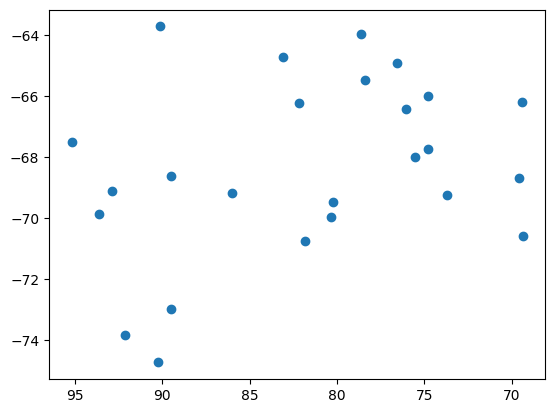

In [14]:
plt.scatter(cl.RA, cl.Dec)
plt.gca().invert_xaxis()
plt.show()

In [ ]:
import numpy, scipy.linalg, scipy.optimize

# angular correlation function of systematic errors:
# x is the angular distance between two points in degrees,
# return the covariance of each component of proper motion in (mas/yr)^2
covfncpm  = lambda x: 0.0004 / (1 + x / 0.3) + 0.0003 * numpy.exp(-x / 12.0)

# a similar covariance function for parallax, return value in mas^2
covfncplx = lambda x: 0.00005 / (1 + x / 0.3) + 0.00007 * numpy.exp(-x / 30.0 - (x / 50.0)**2)

def angular_distance(ra0, dec0, ra1, dec1):
    '''
    Compute the angular distance between two points on a sphere (coordinates expressed in degrees)
    '''
    d2r = numpy.pi/180  # degrees to radians
    return 2 * numpy.arcsin( (numpy.sin( (dec0-dec1)*0.5 * d2r )**2 +
        numpy.cos(dec0 * d2r) * numpy.cos(dec1 * d2r) * numpy.sin( (ra0-ra1)*0.5 * d2r )**2 )**0.5 ) / d2r


def get_mean_pm(ra, dec, pmra, pmdec, pmra_error, pmdec_error, pmra_pmdec_corr, sigma=0, rsigma=numpy.inf, covfnc=None):
    '''
    Compute the mean proper motion (PM) and possibly the internal PM dispersion for a cluster of stars.

    Input consists of several arrays of length N (the number of stars), as given in the Gaia catalogue:
    ra -- right ascension (azimuthal angle, or longitude) of stars, measured in degrees
    dec -- declination (latitude), measured in degrees [-90 to +90]
    pmra -- PM in the ra direction: d(ra)/dt * cos(dec), measured in mas/yr
    pmdec -- PM in the dec direction
    pmra_error -- statistical uncertainty of pmra [mas/yr]
    pmdec_error -- same for pmdec
    pmra_pmdec_corr -- correlation coefficient between errors in pmra and pmdec [-1 to 1]

    Additional input parameters:
    sigma -- internal PM dispersion. If None, then this quantity will be inferred from the input data,
    if the value is provided, it will be used without modifications.
    rsigma -- spatial radius of the internal PM dispersion profile: sigma(R) = sigma / (1 + (R/rsigma)**2)**0.25,
    where R is the angular distance from the cluster center. If set to infinity, the internal dispersion
    is assumed to be the same everywhere, otherwise it declines with radius.
    covfnc -- spatial covariance function of systematic errors.
    If None, the errors are assumed to be uncorrelated; possible choices are covfnc1 or covfnc2.

    Output is a tuple with the following values:
    mean_pmra, mean_pmdec -- the components of the mean PM of the cluster center-of-mass;
    mean_pmra_error, mean_pmdec_error -- uncertainties on these mean PM;
    mean_pmra_pmdec_corr -- correlation coefficient of the uncertainties;
    sigma_value -- inferred internal PM dispersion (if sigma==None), or a copy of the input sigma if it was provided;
    sigma_error -- uncertainty on sigma_value, or 0 if it was fixed to the input value.
    '''

    nstar  = len(ra)
    pmboth = numpy.column_stack((pmra, pmdec)).reshape(-1)  # interleaved pmra,pmdec for each star

    meanra = numpy.median(ra)
    meandec= numpy.median(dec)
    # assumed functional form of PM dispersion (may be arbitrary, here use a particular choice;
    # note that the amplitude of dispersion may be a free parameter, only the spatial profile is fixed
    sig2mul= 1 / (1 + angular_distance(ra, dec, meanra, meandec)**2 / rsigma**2)**0.5

    if sigma is None and covfnc is None:  # should have a separate (simplified) treatment for this case,
        covfnc = lambda x: x*0            # but instead use the general machinery with covfnc set to zero

    if not covfnc is None:
        # covariance matrix of systematic errors depending on the distance between two stars:
        # [ [ C11  C12  ...  C1n ]
        #   [ C12  C22  ...  C2n ]
        #   [ ...  ...  ...  ... ]
        #   [ C1n  C2n  ...  Cnn ] ]
        # where Cij = covfnc(angular_distance(star_i, star_j))
        covmat = numpy.array([ covfnc( angular_distance(ra, dec, ra0, dec0) )
            for ra0, dec0 in zip(ra, dec) ])

        # convert to a 2x larger matrix with diagonal 2x2 blocks (checkerboard pattern):
        # [ [ C11   0   C12   0   ...  C1n   0  ]
        #   [  0   C11   0   C12  ...   0   C1n ]
        #   [ C12   0   C22   0   ...  C2n   0  ]
        #   [  0   C12   0   C22  ...   0   C2n ]
        #   [ ...  ...  ...  ...  ...  ...  ... ]
        #   [ C1n   0   C2n   0   ...  Cnn   0  ]
        #   [  0   C1n   0   C2n  ...   0   Cnn ] ]
        covmat2= numpy.kron(covmat, numpy.eye(2))

        # add 2x2 blocks along the main diagonal:
        # [ [ E1xx E1xy  0    0   ...   0    0  ]
        #   [ E1xy E1yy  0    0   ...   0    0  ]
        #   [  0    0   E2xx E2xy ...   0    0  ]
        #   [ ...  ...  ...  ...  ...  ...  ... ]
        #   [  0    0    0    0   ...  Enxy Enyy] ]
        # where the the 2x2 blocks are the covariance matrices of random errors
        # for each star, and optionally the internal velocity dispersion (sigma):
        # [ [  pmra_err^2 + sigma^2          corr * pmra_err * pmdec_err ]
        #   [  corr * pmra_err * pmdec_err   pmdec_err^2 + sigma^2       ] ]

        # distance between two subsequent diagonal elements in the flattened corrmat2
        stride = 2*(2*nstar+1)
        covmat2.flat[        0::stride] += pmra_error **2
        covmat2.flat[2*nstar+1::stride] += pmdec_error**2
        covmat2.flat[        1::stride] += pmra_error * pmdec_error * pmra_pmdec_corr
        covmat2.flat[2*nstar  ::stride] += pmra_error * pmdec_error * pmra_pmdec_corr
        P = numpy.tile(numpy.eye(2), (nstar,1))   # [ [1,0], [0,1], [1,0], [0,1], ... ]

        if not sigma is None:
            covmat2.flat[::stride//2] += numpy.repeat(sigma**2 * sig2mul, 2)

            # obtain the Cholesky decomposition of covariance matrix
            chol  = numpy.linalg.cholesky(covmat2)
            CinvP = scipy.linalg.cho_solve((chol, True), P)
            covar = numpy.linalg.inv(numpy.dot(CinvP.T, P))        # covariance of uncertainties in mean pmra,pmdec
            sol   = numpy.dot(covar, numpy.dot(CinvP.T, pmboth))   # mean pmra,pmdec (the solution)
            sigval= sigma  # known value provided as input
            sigerr= 0.     # with no uncertainty

        else:

            Lambda, Q = scipy.linalg.eigh(covmat2, numpy.diag(numpy.repeat(sig2mul, 2)))
            y = numpy.dot(pmboth, Q)
            R = numpy.dot(Q.T, P)

            # if we do not know sigma, we find it from the condition that the derivative of log-likelihood
            # w.r.t. sigma^2 is zero; this means solving a 1d equation for sigma^2, in which for any trial
            # value of sigma^2 we first obtain the solution of a linear system for (meanpmra, meanpmdec),
            # and then substitute it into d(ln L)/d(sigma^2), which is a nonlinear function of sigma^2.
            def rootfindersigma(sigma2):
                D    = (Lambda + sigma2)**-1                 # diag(D) = diag[ 1 / (lambda_k + sigma^2) ]
                RTDR = numpy.einsum('ki,k,kj->ij', R, D, R)  # R^T  diag(D)  R
                RTDy = numpy.einsum('ki,k,k->i',   R, D, y)  # R^T  diag(D)  y
                mubar= numpy.linalg.solve(RTDR, RTDy)
                return numpy.sum( ( (y - numpy.dot(R, mubar)) * D )**2 - D)

            # first need to bracket the root from above (assuming that the lower bracket is at 0)
            maxsigma2 = 1.0
            while rootfindersigma(maxsigma2)>0:
                maxsigma2 *= 4
            # then find the exact root
            try:
                sigma2 = scipy.optimize.brentq(rootfindersigma, 0, maxsigma2)
            except:  # may fail if the best-fit sigma^2 is less than 0, then replace it by 0
                sigma2 = 0.

            # after having found the best-fit sigma, we again obtain the solution for (meanpmra, meanpmdec)
            # from a linear system, and then compute the hessian of -ln(L) w.r.t. all three parameters
            # (meanpmra, meanpmdec, sigma).
            # The inverse of this hessian is the covariance matrix for the best-fit parameters.
            D      = (Lambda + sigma2)**-1
            RTDR   = numpy.einsum('ki,k,kj->ij', R, D, R)
            RTDy   = numpy.einsum('ki,k,k->i',   R, D, y)
            sol    = numpy.linalg.solve(RTDR, RTDy)  # inferred mean PM of the cluster
            sigval = sigma2**0.5                     # inferred internal PM dispersion
            z      = y - numpy.dot(R, sol)           # difference between model prediction and actual PM
            H      = numpy.zeros((3, 3))  # overall hessian
            H[:2,:2] = RTDR               # top-left 2x2 block of the hessian is [ R^T  diag(D)  R ]
            H[2,2] = numpy.sum( 4 * sigma2 * z**2 * D**3 - (2 * sigma2 + z**2) * D**2 + D )  # bottom-right element
            H[2,:2]= numpy.dot(R.T, z * D**2) * 2*sigval   # two remaining values in the bottom row
            H[:2,2]= H[2,:2]                               # ..and symmetrically transposed ones in the right column
            invH   = numpy.linalg.inv(H)
            covar  = invH[0:2, 0:2]    # covariance matrix for meanpmra, meanpmdec
            sigerr = invH[2, 2]**0.5   # standard deviation of sigma (don't output its correlations with meanpmra, meanpmdec)

    else:  # a simpler case with no spatial correlations and known sigma
        covmat = numpy.zeros((nstar, 2, 2))
        covmat[:,0,0] = pmra_error **2 + sigma**2 * sig2mul
        covmat[:,1,1] = pmdec_error**2 + sigma**2 * sig2mul
        covmat[:,0,1] = pmra_error * pmdec_error * pmra_pmdec_corr
        covmat[:,1,0] = pmra_error * pmdec_error * pmra_pmdec_corr
        CinvA = numpy.linalg.inv(covmat).reshape(2*nstar, 2)
        covar = numpy.linalg.inv(numpy.sum(CinvA.reshape(nstar, 2, 2), axis=0))
        sol   = numpy.dot(covar, numpy.dot(CinvA.T, pmboth))
        sigval= sigma
        sigerr= 0.

    return sol[0], sol[1], covar[0,0]**0.5, covar[1,1]**0.5, covar[0,1] / (covar[0,0]*covar[1,1])**0.5, sigval, sigerr


def get_mean_plx(ra, dec, plx, plx_error, covfnc=None, gmag=None):
    '''
    Compute the mean parallax for a cluster of stars, possibly taking into account
    spatially correlated systematic errors.

    Input consists of several arrays of length N (the number of stars), as given in the Gaia catalogue:
    ra -- right ascension (azimuthal angle, or longitude) of stars, measured in degrees
    dec -- declination (latitude), measured in degrees [-90 to +90]
    plx -- parallax
    plx_error -- parallax uncertainty
    covfnc (optional) -- spatial covariance function for parallax errors, e.g., covfncplx, or None
    gmag (optional) -- G-band magnitude (used to scale the parallax covariance function)

    Return: mean parallax and its uncertainty
    '''

    nstar  = len(ra)
    if not covfnc is None:
        # covariance matrix of systematic errors depending on the distance between two stars:
        # [ [ C11  C12  ...  C1n ]
        #   [ C12  C22  ...  C2n ]
        #   [ ...  ...  ...  ... ]
        #   [ C1n  C2n  ...  Cnn ] ]
        # where Cij = covfnc(angular_distance(star_i, star_j))
        covmat = numpy.array([ covfnc( angular_distance(ra, dec, ra0, dec0) )
            for ra0, dec0 in zip(ra, dec) ])

        # magnitude-dependent scaling of covariance function
        if not gmag is None:
            covfncmul = numpy.maximum(1.0, gmag-17)
            for i in range(len(plx)):
                covmat[i] *= numpy.minimum(covfncmul, covfncmul[i])

        # add statistical errors along the main diagonal:
        # [ [ E1   0  ...  0  ]
        #   [  0  E2  ...  0  ]
        #   [ ... ... ... ... ]
        #   [  0   0  ... En  ] ]
        covmat += numpy.diag(plx_error**2)

        # obtain the Cholesky decomposition of covariance matrix
        chol  = numpy.linalg.cholesky(covmat)
        Cinv  = scipy.linalg.cho_solve((chol, True), numpy.ones(len(plx)))
        covar = numpy.sum(Cinv)**-1           # squared parallax uncertainty
        mean  = numpy.dot(Cinv, plx) * covar  # mean parallax (the solution)

    else:  # a simpler case with no spatial correlations
        covar = numpy.sum(plx_error**-2)**-1
        mean  = numpy.sum(plx * plx_error**-2) * covar

    return mean, covar**0.5


def create_cluster(nstar, radius, sigma=0, covfnc=None):
    '''
    Create a mock cluster of stars.

    Input:
    nstar -- number of stars.
    radius -- radius of the cluster (in degrees); the surface density profile is Gaussian with this radius.
    sigma -- internal PM dispersion of stars in the cluster; its spatial dependence is
    sigma(R) = sigma / (1 + (R/radius)**2)**0.25
    covfnc -- spatial covariance function of systematic errors; if None then no correlated systematic errors are added,
    only the random (statistical) errors with a realistic distribution of magnitudes.

    Output:
    five arrays that may be provided as input for the routine get_mean_pm:
    ra, dec, pmra, pmdec, pmra_error, pmdec_error, pm_corr
    '''
    rsigma     = radius
    ra         = numpy.random.normal(size=nstar) * radius
    dec        = numpy.random.normal(size=nstar) * radius
    sigvar     = sigma / (1 + (ra**2 + dec**2) / rsigma**2)**0.25   # spatially variable dispersion
    pmra       = numpy.random.normal(size=nstar) * sigvar           # true values
    pmdec      = numpy.random.normal(size=nstar) * sigvar
    pm_err_mag = numpy.random.gamma(shape=2, scale=0.5, size=nstar) # size of error ellipse
    pm_err_rat = numpy.random.uniform(0.2, 1, size=nstar)           # axis ratio of --"--
    pm_err_dir = numpy.random.uniform(0, numpy.pi, size=nstar)      # orientation of --"--
    pm_err_maj = pm_err_mag * pm_err_rat**-0.5                      # semimajor axis
    pm_err_min = pm_err_mag * pm_err_rat**0.5                       # semiminor axis
    tan        = numpy.tan(pm_err_dir)
    pmra_error = ( (pm_err_maj**2 + pm_err_min**2 * tan**2) / (1 + tan**2) )**0.5
    pmdec_error= ( (pm_err_min**2 + pm_err_maj**2 * tan**2) / (1 + tan**2) )**0.5
    pm_corr    = tan / (1 + tan**2) * (pm_err_maj**2 - pm_err_min**2) / (pmra_error * pmdec_error)
    # add errors to the true values of pmra, pmdec
    if not covfnc is None:
        # same steps as in the above routine
        covmat = numpy.array([ covfnc( angular_distance(ra, dec, ra0, dec0) )
            for ra0, dec0 in zip(ra, dec) ])
        covmat2= numpy.zeros((2*nstar, 2*nstar))
        covmat2[0::2, 0::2] = covmat
        covmat2[1::2, 1::2] = covmat
        stride = 2*(2*nstar+1)
        covmat2.flat[        0::stride] += pmra_error **2
        covmat2.flat[2*nstar+1::stride] += pmdec_error**2
        covmat2.flat[        1::stride] += pmra_error * pmdec_error * pm_corr
        covmat2.flat[2*nstar  ::stride] += pmra_error * pmdec_error * pm_corr
        chol  = numpy.linalg.cholesky(covmat2)
        errs  = numpy.dot(chol, numpy.random.normal(size=2*nstar))   # noise/measurement errors
        pmra += errs[0::2]
        pmdec+= errs[1::2]
    else:  # simpler case with no correlated errors
        noise1, noise2 = numpy.random.normal(size=(2,nstar))
        pmra += pmra_error  *  noise1
        pmdec+= pmdec_error * (noise2 * (1-pm_corr**2)**0.5 + noise1 * pm_corr)

    return ra, dec, pmra, pmdec, pmra_error, pmdec_error, pm_corr


##### test/example of the usage for the above code #####

if __name__ == '__main__':
    import sys
    plot = len(sys.argv)>1   # run with any command-line argument to plot the demo results
    if plot: import matplotlib.patches, matplotlib.pyplot as plt

    def ellipse(meanx, meany, sigmax, sigmay, corr, **kw):
        # draw error ellipse defined by standard deviations and correlation coefficient
        if corr==0:
            return matplotlib.patches.Ellipse((meanx,meany), width=2*sigmax, height=2*sigmay, **kw)
        sum = sigmax**2+sigmay**2
        dif = sigmax**2-sigmay**2
        det = (dif**2 + (2*sigmax*sigmay*corr)**2)**0.5
        ang = numpy.arctan2(2*corr*sigmax*sigmay, dif+det)
        return matplotlib.patches.Ellipse((meanx,meany), width=(2*(sum+det))**0.5, height=(2*(sum-det))**0.5, angle=180/numpy.pi*ang, **kw)


    def test(nstar, radius, sigma=0, covfnc=None, fix_sigma=False):
        ra, dec, pmra, pmdec, pmra_err, pmdec_err, pm_corr = create_cluster(nstar, radius, sigma, covfnc)
        meanpmra, meanpmdec, errpmra, errpmdec, corr, sigma, sigerr = \
            get_mean_pm(ra, dec, pmra, pmdec, pmra_err, pmdec_err, pm_corr, sigma if fix_sigma else None, radius, covfnc)
        print("pmra=%.3f +- %.3f,  pmdec=%.3f +- %.3f,  sigma=%.3f +- %.3f" % \
            (meanpmra, errpmra, meanpmdec, errpmdec, sigma, sigerr))
        if plot:
            for i in range(nstar):
                plt.gca().add_artist(ellipse(pmra[i], pmdec[i], pmra_err[i], pmdec_err[i], pm_corr[i],
                    alpha=0.1, lw=0, color=numpy.random.rand(3,1)))
            plt.plot(0, 0, 'o', color='b', markeredgewidth=0)  # true value
            plt.errorbar(meanpmra, meanpmdec, xerr=errpmra, yerr=errpmdec, color='r', markeredgewidth=0)
            plt.xlim(-5, 5)
            plt.ylim(-5, 5)
            plt.show()

### From Files:

In [ ]:
cl.pmra = cl.ghpmra  
cl.pmdec = cl.ghpmdec 
cl.pmra_err = cl.ghpmra_err 
cl.pmdec_err = cl.ghpmdec_err

In [37]:
q1, q2, d, radiff, decdiff = [],[],[],[],[]
r1, r2, d1, d2 = [],[],[],[]

cl = pd.read_csv('LMC Bennet.csv')

 

for i in range(len(cl)):
    name = cl['cluster name'][i]
    f1 = 'vLMC/v'+name.split()[0]+'_'+name.split()[1]+'.csv'
    a = pd.read_csv(f1)
    
    pr1 = cl.pmra[i]
    pd1 = cl.pmdec[i]
    
    pr2 = a.v[0]
    pd2 = a.v[1]
    
    er1 = cl.pmra_err[i]
    ed1 = cl.pmdec_err[i]
    
    er2 = a.v[2]
    ed2 = a.v[3]
    
    e1 = np.sqrt(((pr1*er1)**2 + (pd1*ed1)**2) / (pr1**2 + pd1**2))
    e2 = np.sqrt(((pr2*er2)**2 + (pd2*ed2)**2) / (pr2**2 + pd2**2))
    
    diff = np.sqrt((pr1-pr2)**2 + (pd1-pd2)**2)
    
    r1.append(pr1)
    r2.append(pr2)
    d1.append(pd1)
    d2.append(pd2)
    radiff.append(pr1-pr2)
    decdiff.append(pd1-pd2)
    
    disp = a.v[5]
    d.append(disp)
    
    q1.append(diff/np.sqrt(e1**2+e2**2))
    q2.append(diff/disp)
    
    print(name, '--', diff, '--', diff/np.sqrt(e1**2+e2**2), '--', diff/disp)
    

q1, q2, d, radiff, decdiff = np.array(q1), np.array(q2), np.array(d), np.array(radiff), np.array(decdiff)
r1, r2, d1, d2 = np.array(r1), np.array(r2), np.array(d1), np.array(d2)

/tmp/ipykernel_355/3730710381.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  q2.append(diff/disp)
/tmp/ipykernel_355/3730710381.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  print(name, '--', diff, '--', diff/np.sqrt(e1**2+e2**2), '--', diff/disp)
/tmp/ipykernel_355/3730710381.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  q2.append(diff/disp)
/tmp/ipykernel_355/3730710381.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  print(name, '--', diff, '--', diff/np.sqrt(e1**2+e2**2), '--', diff/disp)


NGC 1644 -- 0.11347254061921982 -- 0.8702689829792905 -- inf
NGC 1651 -- 0.21330262660400315 -- 1.1828986270923383 -- inf
NGC 1652 -- 0.4781687553682564 -- 1.4588402700836447 -- 4.313533771647813
NGC 1756 -- 0.018753499701220953 -- 0.6921983538048765 -- 0.10026568619615812
NGC 1783 -- 0.05469645103061196 -- 1.0975157112999565 -- 0.33714503775105364
NGC 1786 -- 0.18026615522629455 -- 1.7785618841459927 -- 0.8974581227496502
NGC 1806 -- 0.06960383802963263 -- 1.0071617323834987 -- 0.2966763167873519
NGC 1818 -- 0.143860698639225 -- 3.5302803783677206 -- 0.7413970330345427
NGC 1831 -- 0.06470836310031544 -- 1.2515234477972008 -- 0.46383215932396976
NGC 1866 -- 0.06683703098073569 -- 1.2451524508246086 -- 0.4020017507200846
NGC 1868 -- 0.07190720475713608 -- 0.42144954180365557 -- 0.5330156667444936
NGC 1928 -- 0.07144363897010436 -- 2.5593576668965525 -- 0.17550167590922255
NGC 1939 -- 0.04319598270467997 -- 1.5272606381684029 -- 0.11909681030379471
NGC 1978 -- 0.20560305464846143 -- 3.77

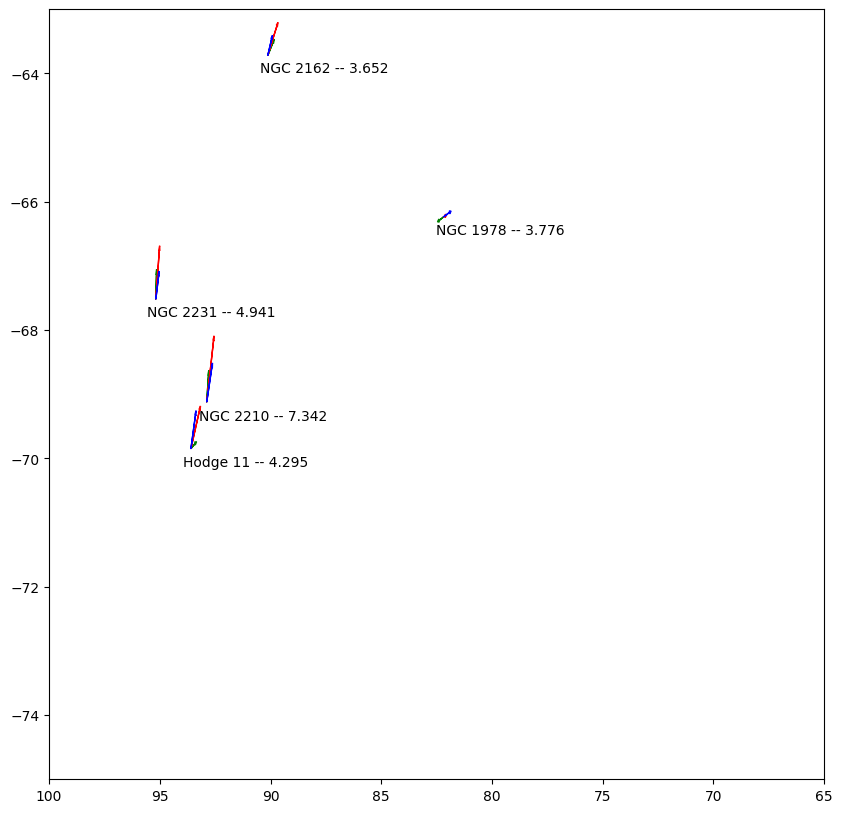

In [43]:
s=1
sq=10
k=1.004

plt.figure(figsize=(sq, sq))
for i in range(len(cl)):
    if q2[i] < 1 or q1[i] < 3:
        continue
    plt.arrow(cl.RA[i], cl.Dec[i], s*radiff[i], s*decdiff[i], head_width=0.05, color='g')
    
    plt.arrow(cl.RA[i], cl.Dec[i], r1[i]-1.858, d1[i]-0.385, head_width=0.05, color='r')
    plt.arrow(cl.RA[i], cl.Dec[i], r2[i]-1.858, d2[i]-0.385, head_width=0.05, color='b')
    
    name = cl['cluster name'][i]
    plt.text(cl.RA[i]*k, cl.Dec[i]*k, name+' -- '+str(np.round(q1[i],3)))

plt.xlim(65,100)
plt.ylim(-75,-63)
plt.gca().invert_xaxis()
plt.show()

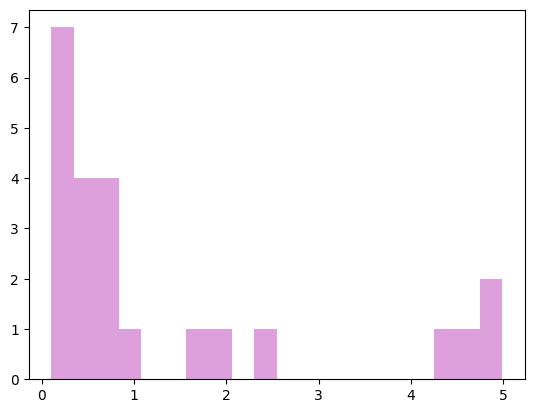

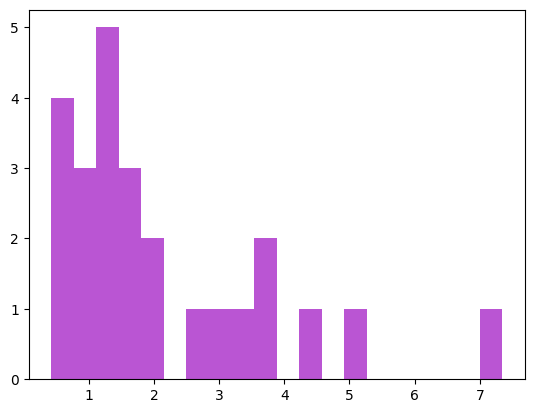

In [30]:
plt.hist(q2[np.where(q2<20)], bins=20, color='plum')
plt.show()
plt.hist(q1, bins=20, color='mediumorchid')
plt.show()

In [28]:
len(np.where(q2>1.5)[0])

9

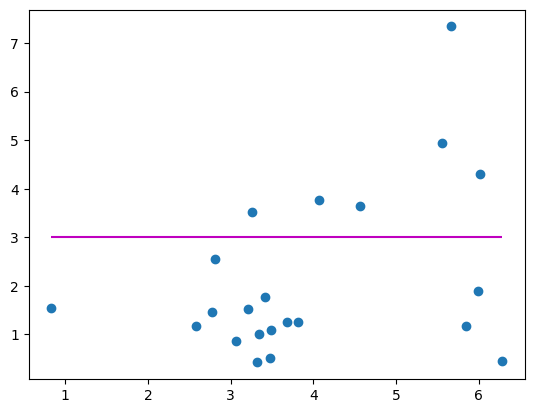

In [17]:
cl.coord = cl.phi
plt.scatter(cl.coord, q1)
plt.hlines([3], np.min(cl.coord), np.max(cl.coord), color='m')

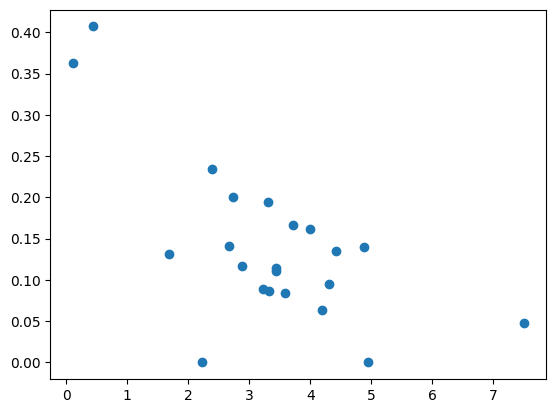

In [10]:
plt.scatter(cl.coord, d)